# The quality of a scientific manuscript given by a peer-reviewed report in three dimensions: Accessibility, Contribution and Experimentation (ConAccExp)
In the notebook, we are going to code a machine based in deep learning (by using sciBERT) to learn three fundamentals aspects Contribution, Accessibility and Experimentation which must appear in a report of a reviewer (at least some of them). Also this aspects can have a setiment (positive and negative). This notebook is based on notebook in https://github.com/PrabhatkrBharti/Aspect-category-and-sentiment-extraction

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')





Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle


In [ ]:
## !pip install -U tensorflow==2.7.1
## !pip install scikeras
!pip install pretty-confusion-matrix
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers
#!pip install textgenie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl

In [ ]:
import tensorflow as tf
from keras.layers import Bidirectional, Input, Dense, Layer, Dropout, LSTM, RepeatVector, Concatenate, Flatten,Conv2D
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K



In [ ]:
#Transfomr aspect to constructs
path_data='/content/gdrive/My Drive/Colab Notebooks/tesis_juanjo/Accesibilidad_Contribution_Reports/data'
name = path_data+'/upsampled_ohe_aspect_GoldStandard.csv'

data_aspect = pd.read_csv(name,sep=',')
print(data_aspect.head())
print(data_aspect.isna().sum())
print(len(data_aspect.columns))
convert_aspe_constr={'CLA':'Accessibility','SOU':"Accessibility",'MOT':"Contribution",'ORI':'Contribution',
                     'CMP':'Experimentation','SUB':'Experimentation'};

aspect=['CLA','SOU','MOT','ORI','CMP','SUB']
constructs=['Accessibility',"Contribution",'Experimentation']
columns_con=['review_ID','review','Accessibility','Contribution','Experimentation','polarity']
data =pd.DataFrame(columns=columns_con+aspect,index=data_aspect.index)
for pos in range(0,len(data_aspect.index)):
  i=data_aspect.index[pos]
  if (data_aspect.loc[i,'REP']==0):
    data.loc[i,'review_ID']=data_aspect.loc[i,'review_ID']
    data.loc[i,'review']=data_aspect.loc[i,'review']
    data.loc[i,'polarity']=data_aspect.loc[i,'polarity']
    data.loc[i,constructs]=0
    data.loc[i,aspect]=data_aspect.loc[i,aspect]
    for a in aspect:
      if data_aspect.loc[i,a]==1:
        construct= convert_aspe_constr[a]
        #print("Aspect ",a," Construct ",construct)
        data.loc[i,construct]=1
data=data.dropna()
print(data.isna().sum())
print(data.head())
n_out = path_data+'/data_augment.csv'
data.to_csv(n_out,sep=',')





      review_ID                                             review  CLA  CMP  \
0   ICLR_2017_1  is a very interesting and fairly easy to read ...    1    0   
1   ICLR_2017_1                                               This    0    0   
2   ICLR_2017_1  What I like is that the idea is super simple a...    0    0   
3   ICLR_2017_1                                               This    0    0   
4  ICLR_2017_10                                the paper is poorly    1    0   

   MOT  ORI  REP  SOU  SUB  polarity aspects  
0    0    0    0    0    0         1     CLA  
1    0    1    0    0    0         1     ORI  
2    0    1    0    0    0         1     ORI  
3    0    1    0    0    0         1     ORI  
4    0    0    0    0    0        -1     CLA  
review_ID    0
review       0
CLA          0
CMP          0
MOT          0
ORI          0
REP          0
SOU          0
SUB          0
polarity     0
aspects      0
dtype: int64
11
review_ID          0
review             0
Accessibility 

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
#  HYPERPARAMETERS
NUM_OF_CONSTRUCTS = 3 #ACCESSIBILITY, CONTRIBUTION and EXPERIMENTATION
NUM_OF_ASPECTS_ORI= 6 # CLA, MOT, SUB SOU, CMP, ORI

EPOCHS = 150
MAXLEN = 768 # Since SciBERT returns 768 embeddings vector
LSTM_UNITS = 256
BATCH_SIZE =64

path_data='/content/gdrive/My Drive/Colab Notebooks/tesis_juanjo/Accesibilidad_Contribution_Reports/data'


### **1) DATASET** :

**A.Aspects Categor
y**
1. Accessibility
2. Contribution
2. Experimentation
<br>

**B. Aspect Sentiment** <br>
1.  Positive
2.  Negative




### **2) LOAD DATASET**
Define train and test set. Train 70% test 30%


**NOTE:** Update the URL PATH accordingly

In [ ]:
#We have create data_augment.csv
path_data='/content/gdrive/My Drive/Colab Notebooks/tesis_juanjo/Accesibilidad_Contribution_Reports/data'
n_out = path_data+'/data_augment.csv'
data=pd.read_csv(n_out,sep=',')
print(data.columns)

print("Total Sentences ", len(data))
aux=data.query('CLA==1')
print("CLA ", aux['CLA'].sum())
print("SUB ", data.query('SUB==1')['SUB'].sum())
print("ORI ", data.query('ORI==1')['ORI'].sum())
print("MOT ", data.query('MOT==1')['MOT'].sum())
print("SUS ", data.query('SUB==1')['SUB'].sum())
print("CMP ", data.query('CMP==1')['CMP'].sum())
print("POS ", data.query('polarity==1')['polarity'].sum())
print("NEG ", data.query('polarity==-1')['polarity'].sum())


acce_pos = data.query('Accessibility==1 & polarity==1')
print("Accesibility_positive ",acce_pos['Accessibility'].sum())
acce_neg = data.query('Accessibility==1 & polarity==-1')
print("Accesibility_negative ",acce_neg['Accessibility'].sum())


con_pos = data.query('Contribution==1 & polarity==1')
print("Contribution_positive ",con_pos['Contribution'].sum())
con_neg = data.query('Contribution==1 & polarity==-1')
print("Contribution_negative ",con_neg['Contribution'].sum())


exp_pos = data.query('Experimentation==1 & polarity==1')
print("Experimentation_positive ",exp_pos['Experimentation'].sum())
exp_neg = data.query('Experimentation==1 & polarity==-1')
print("Experimentation_negative ",exp_neg['Experimentation'].sum())
print(data.isna().sum())

Index(['Unnamed: 0', 'review_ID', 'review', 'Accessibility', 'Contribution',
       'Experimentation', 'polarity', 'CLA', 'SOU', 'MOT', 'ORI', 'CMP',
       'SUB'],
      dtype='object')
Total Sentences  172752
CLA  28792
SUB  28792
ORI  28792
MOT  28792
SUS  28792
CMP  28792
POS  76847
NEG  -95905
Accesibility_positive  26059
Accesibility_negative  31525
Contribution_positive  38540
Contribution_negative  19044
Experimentation_positive  12248
Experimentation_negative  45336
Unnamed: 0         0
review_ID          0
review             0
Accessibility      0
Contribution       0
Experimentation    0
polarity           0
CLA                0
SOU                0
MOT                0
ORI                0
CMP                0
SUB                0
dtype: int64


In [ ]:
print(data.head())



   Unnamed: 0     review_ID  \
0           0   ICLR_2017_1   
1           1   ICLR_2017_1   
2           2   ICLR_2017_1   
3           3   ICLR_2017_1   
4           4  ICLR_2017_10   

                                              review  Accessibility  \
0  is a very interesting and fairly easy to read ...              1   
1                                               This              0   
2  What I like is that the idea is super simple a...              0   
3                                               This              0   
4                                the paper is poorly              1   

   Contribution  Experimentation  polarity  CLA  SOU  MOT  ORI  CMP  SUB  
0             0                0         1    1    0    0    0    0    0  
1             1                0         1    0    0    0    1    0    0  
2             1                0         1    0    0    0    1    0    0  
3             1                0         1    0    0    0    1    0    0  
4          

In [ ]:
from sklearn.model_selection import train_test_split

aspect_polarity=['Accessibility', 'Contribution','Experimentation','polarity']
aspect=['CLA','SOU','MOT','ORI','CMP','SUB']
x_train,x_test,y_train,y_test = train_test_split(data["review"],
data[aspect_polarity+aspect],test_size = 0.3, random_state=42)
train_data = pd.concat([x_train , y_train], axis = 1)
test_data = pd.concat([x_test , y_test], axis = 1)
train_data.head()





,review,Accessibility,Contribution,Experimentation,polarity,CLA,SOU,MOT,ORI,CMP,SUB
164459,I think all these clarifications will increase...,1,0,0,-1,1,0,0,0,0,0
66724,I found the paper to be clear and well written,1,0,0,1,1,0,0,0,0,0
133792,The writing and clarity of paper can be improv...,1,0,0,-1,1,0,0,0,0,0
85009,"while this is an interesting result , it seems...",1,0,0,-1,0,1,0,0,0,0
119224,this algorithm is very similar to W-GAN and th...,0,1,0,-1,0,0,0,1,0,0


In [ ]:
aspect_cat= train_data.columns[1:4]
print(aspect_cat)

y_train=train_data[train_data.columns[1:]]
y_test=test_data[test_data.columns[1:]]
y_train['polarity']=y_train['polarity'].where(y_train['polarity']==1,0)
y_test['polarity']=y_test['polarity'].where(y_test['polarity']==1,0)
#print(test_data.head())
print(y_train.head())
print(y_test.head())
#aspect_categories = y_ohe_train.columns[:-1]
#y_ohe_train['polarity'] = np.where(y_ohe_train['polarity'] == -1, 0, 1)
#y_ohe_test['polarity'] = np.where(y_ohe_test['polarity'] == -1, 0, 1)

Index(['Accessibility', 'Contribution', 'Experimentation'], dtype='object')
        Accessibility  Contribution  Experimentation  polarity  CLA  SOU  MOT  \
164459              1             0                0         0    1    0    0   
66724               1             0                0         1    1    0    0   
133792              1             0                0         0    1    0    0   
85009               1             0                0         0    0    1    0   
119224              0             1                0         0    0    0    0   

        ORI  CMP  SUB  
164459    0    0    0  
66724     0    0    0  
133792    0    0    0  
85009     0    0    0  
119224    1    0    0  
        Accessibility  Contribution  Experimentation  polarity  CLA  SOU  MOT  \
113027              1             0                0         1    0    1    0   
162593              0             0                1         0    0    0    0   
23642               0             0               

<ipython-input-7-1b08f725b4a6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['polarity']=y_train['polarity'].where(y_train['polarity']==1,0)
<ipython-input-7-1b08f725b4a6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['polarity']=y_test['polarity'].where(y_test['polarity']==1,0)


In [ ]:
print(y_train.to_numpy())

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [1 0 0 ... 0 0 0]]


In [ ]:

name_train_x_out = path_data+'/sci_emb_train.pkl'
name_test_x_out = path_data+'/sci_emb_test.pkl'

with open(name_train_x_out, 'rb') as df_file_train:
  sci_embeds_train= pickle.load(df_file_train)
with open(name_test_x_out, 'rb') as df_file_test:
  sci_embeds_test= pickle.load(df_file_test)

train_embeds = sci_embeds_train['x']
test_embeds = sci_embeds_test['x']
print(train_embeds)

[[[-0.69265765 -0.00766458  0.7997397  ... -0.4307261   0.388304
   -0.72631633]]

 [[-0.7693981   0.03213955  0.7630115  ... -0.6972388  -0.31612858
   -0.64814126]]

 [[-0.32019725 -0.4142283   0.8857544  ... -0.78428483 -0.2614241
   -0.51105666]]

 ...

 [[-0.6060202  -0.15988506  0.73423487 ... -0.45989394  0.22821915
   -0.4549567 ]]

 [[-0.39316607 -0.54931945  0.84052014 ... -0.55281335  0.7317387
   -0.80211294]]

 [[-0.3250439   0.08844967  0.84346014 ... -0.48848155 -0.5453074
   -0.6806239 ]]]


In [ ]:
train_embeds.shape , y_train.shape

((120926, 1, 768), (120926, 10))

In [ ]:
test_embeds.shape , y_test.shape

((51826, 1, 768), (51826, 10))

### **3) SCIBERT**
To create the encode information of every sentence, this section must be executed. The results will be two file sci_emb_train.pkl and sci_emb_test.pkl which contain the encoded sentences. For the endoce we have use SCIBERT.

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [ ]:
## SCIBERT
embed_model_name = 'gsarti/scibert-nli'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(embed_model_name)
embed_model = AutoModel.from_pretrained(embed_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def sent2embed(model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

#example
sent = train_data.loc[train_data.index[0],'review']
outputs = sent2embed(embed_model, sent)
outputs[1].shape


torch.Size([1, 768])

In [ ]:
# PRE-PROCESS -- SCIBERT-EMBED
import pickle
def sciBertEmbed(reviews, model):
    embed_arr = []
    #start = reviews.index[0]
    total = len(reviews.index)
    pos=0
    for idx in reviews.index:

        if (pos%100==0):
          print(pos,"-------Total ",total)
        pos+=1
        outputs = sent2embed(model, reviews.loc[idx][0])
        embed_arr.append([outputs[1].detach().numpy()[0]])
    embed_train_arr = tf.stack(embed_arr)
    return embed_train_arr

reviews_train=pd.DataFrame(train_data.loc[train_data.index,'review'],columns=None)
reviews_test=pd.DataFrame(test_data.loc[test_data.index,'review'],columns=None)

#get a matrix with rows equal to the number of setences and the number of elements of each row is 768
name_train_x_out = path_data+'/sci_emb_train.pkl'
miembed= sciBertEmbed(reviews_train,embed_model)
x = miembed.numpy()
y = y_train.to_numpy()
with open(name_train_x_out, 'wb') as df_file:
    pickle.dump(obj={'x':x,'y':y}, file = df_file)
print("Codificado Train....")
miembed= sciBertEmbed(reviews_test,embed_model)

name_test_x_out = path_data+'/sci_emb_test.pkl'
x = miembed.numpy()
y = y_test.to_numpy()
with open(name_test_x_out, 'wb') as df_file:
    pickle.dump(obj={'x':x,'y':y}, file = df_file)

0 -------Total  120926
100 -------Total  120926
200 -------Total  120926
300 -------Total  120926
400 -------Total  120926
500 -------Total  120926
600 -------Total  120926
700 -------Total  120926
800 -------Total  120926
900 -------Total  120926
1000 -------Total  120926
1100 -------Total  120926
1200 -------Total  120926
1300 -------Total  120926
1400 -------Total  120926
1500 -------Total  120926
1600 -------Total  120926
1700 -------Total  120926
1800 -------Total  120926
1900 -------Total  120926
2000 -------Total  120926
2100 -------Total  120926
2200 -------Total  120926
2300 -------Total  120926
2400 -------Total  120926
2500 -------Total  120926
2600 -------Total  120926
2700 -------Total  120926
2800 -------Total  120926
2900 -------Total  120926
3000 -------Total  120926
3100 -------Total  120926
3200 -------Total  120926
3300 -------Total  120926
3400 -------Total  120926
3500 -------Total  120926
3600 -------Total  120926
3700 -------Total  120926
3800 -------Total  12092

### Attention Layer**

In [ ]:
class Attention(Layer):

    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences ,
        })
        return config


    def build(self, input_shape):

        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

        super(Attention,self).build(input_shape)

    def call(self, x):
        e =K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        a =K.softmax(e)
        a=K.expand_dims(a,axis=-1)
        output = x*a

        return K.sum(output, axis=1)

### **MODEL 1**: Learn Construct Categories and Sentiment
This model will tagger evey sentence by using Accessibility, Contribution or Experimentation construct and also polarity (negative and positive). Based over this model in the second model will learn aspect-categories.

In [ ]:

#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)

#for every aspect in (Accessibility, Contribution, Experimentation) add an attention layer
attentions=[]
for i in range(NUM_OF_CONSTRUCTS):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)

flatten = Flatten()(concate_attention)


# BRANCH 1: classify Accessibility, Contribution and Experimentation
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)

category_output = Dense(NUM_OF_CONSTRUCTS, activation='softmax', name='CATEGORY_OUTPUT')(b1_x)

# BRANCH 2 classify Polarity
dense2 =  Dense(60, activation='relu', name='SENTIMENT_DENSE')(flatten)
polarity_output = Dense(1, activation='sigmoid', name='SENTIMENT_OUTPUT')(dense2)

multitask_model = Model(inputs=embed, outputs=[category_output, polarity_output])





In [ ]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT': 'categorical_crossentropy',
         'SENTIMENT_OUTPUT': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT': 1.0,
                'SENTIMENT_OUTPUT': 1.0
              }


multitask_model.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam',
                        metrics=['accuracy'])


multitask_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector (RepeatVecto  (None, 1, 512)               0         ['BILSTM[0][0]']              
 r)                                                                                               
                                                                                                  
 attention_1 (Attention)     (None, 512)                  513       ['repeat_vector[0][0]']   

In [ ]:
tf.keras.utils.plot_model(multitask_model, to_file='multi-task_model.png', show_shapes=True)


Index(['Accessibility', 'Contribution', 'Experimentation', 'polarity'], dtype='object')


#### FIT MODEL 1

In [ ]:

history = multitask_model.fit(
                          train_embeds,
                          y =  {
                          'CATEGORY_OUTPUT': y_train[aspect_cat].values,
                          'SENTIMENT_OUTPUT': y_train.polarity.values

                          },
                           validation_data = (test_embeds, {
                          'CATEGORY_OUTPUT': y_test[aspect_cat].values,
                          'SENTIMENT_OUTPUT': y_test.polarity.values
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                           batch_size=BATCH_SIZE,
                           callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/ConAccExp-ModelPati10.h5'
multitask_model.save(SAVE_PATH, overwrite=True, save_format="tf")
print("Weights Saved")

Epoch 1/150
1890/1890 - 21s - loss: 0.7014 - CATEGORY_OUTPUT_loss: 0.5206 - SENTIMENT_OUTPUT_loss: 0.1808 - CATEGORY_OUTPUT_accuracy: 0.7821 - SENTIMENT_OUTPUT_accuracy: 0.9254 - val_loss: 0.6584 - val_CATEGORY_OUTPUT_loss: 0.4882 - val_SENTIMENT_OUTPUT_loss: 0.1702 - val_CATEGORY_OUTPUT_accuracy: 0.7992 - val_SENTIMENT_OUTPUT_accuracy: 0.9288 - lr: 0.0010 - 21s/epoch - 11ms/step
Epoch 2/150
1890/1890 - 13s - loss: 0.5943 - CATEGORY_OUTPUT_loss: 0.4450 - SENTIMENT_OUTPUT_loss: 0.1493 - CATEGORY_OUTPUT_accuracy: 0.8156 - SENTIMENT_OUTPUT_accuracy: 0.9386 - val_loss: 0.5838 - val_CATEGORY_OUTPUT_loss: 0.4380 - val_SENTIMENT_OUTPUT_loss: 0.1458 - val_CATEGORY_OUTPUT_accuracy: 0.8187 - val_SENTIMENT_OUTPUT_accuracy: 0.9413 - lr: 0.0010 - 13s/epoch - 7ms/step
Epoch 3/150
1890/1890 - 13s - loss: 0.5555 - CATEGORY_OUTPUT_loss: 0.4175 - SENTIMENT_OUTPUT_loss: 0.1380 - CATEGORY_OUTPUT_accuracy: 0.8286 - SENTIMENT_OUTPUT_accuracy: 0.9439 - val_loss: 0.5623 - val_CATEGORY_OUTPUT_loss: 0.4238 - va

In [ ]:
SAVE_PATH=path_data+'/ConAccExp-Model.h5'
multitask_model.save(SAVE_PATH, overwrite=True, save_format="tf")
print("Weights Saved")

Weights Saved


In [ ]:
# LOAD MODEL
from keras.models import load_model
SAVE_PATH=path_data+'/ConAccExp-Model.h5'
LOAD_PATH = SAVE_PATH

model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})

print("MODEL LOADED\n\n")

model.evaluate(test_embeds, [y_test[aspect_cat].values, y_test.polarity.values] )

MODEL LOADED


1620/1620 [==============================] - 6s 3ms/step - loss: 0.6297 - CATEGORY_OUTPUT_loss: 0.4889 - SENTIMENT_OUTPUT_loss: 0.1408 - CATEGORY_OUTPUT_accuracy: 0.9332 - SENTIMENT_OUTPUT_accuracy: 0.9766


[0.6296980977058411,
 0.48885124921798706,
 0.14084690809249878,
 0.93323814868927,
 0.9765561819076538]

### MODEL 1: ANALYSIS

In [ ]:
history.history.keys()

dict_keys(['loss', 'CATEGORY_OUTPUT_loss', 'SENTIMENT_OUTPUT_loss', 'CATEGORY_OUTPUT_accuracy', 'SENTIMENT_OUTPUT_accuracy', 'val_loss', 'val_CATEGORY_OUTPUT_loss', 'val_SENTIMENT_OUTPUT_loss', 'val_CATEGORY_OUTPUT_accuracy', 'val_SENTIMENT_OUTPUT_accuracy', 'lr'])

In [ ]:
metrics_keys = list(history.history.keys())

loss = history.history[metrics_keys[0]]
category_loss = history.history[metrics_keys[1]]
polarity_loss = history.history[metrics_keys[2]]
category_acc = history.history[metrics_keys[3]]
polarity_acc = history.history[metrics_keys[4]]
val_loss = history.history[metrics_keys[5]]
val_category_loss = history.history[metrics_keys[6]]
val_polarity_loss = history.history[metrics_keys[7]]
val_category_acc = history.history[metrics_keys[8]]
val_polarity_acc = history.history[metrics_keys[9]]


print("\nCATEGORY ACCURACY : " , category_acc)
print("\nPOLARITY ACCURACY : " , polarity_acc)
print("\nVAL CATEGORY ACCURACY : " ,val_category_acc)
print("\nVAL POLARITY ACCURACY : " ,val_polarity_acc)

print("\nLOSS : " , loss)
print("\nVAL LOSS : " , val_loss)
print("\nCATEGORY LOSS : " , category_loss)
print("\nCATEGORY VAL LOSS : " , val_category_loss)
print("\nPOLARITY LOSS : " , polarity_loss)
print("\nVAL POLARITY LOSS : " , val_polarity_loss)


CATEGORY ACCURACY :  [0.7841241955757141, 0.8172518610954285, 0.8285562992095947, 0.8381654620170593, 0.8451036214828491, 0.8522236943244934, 0.8567057251930237, 0.8617914915084839, 0.8685890436172485, 0.874220609664917, 0.8799431324005127, 0.8838711380958557, 0.8906852006912231, 0.8946959376335144, 0.8996080160140991, 0.9053305387496948, 0.9108049273490906, 0.9141293168067932, 0.9183384776115417, 0.9225394129753113, 0.9247804284095764, 0.9279311299324036, 0.9299240708351135, 0.9340340495109558, 0.9367051124572754, 0.9382680058479309, 0.9418652653694153, 0.9434612989425659, 0.944585919380188, 0.9468848705291748, 0.9490018486976624, 0.9508377313613892, 0.9512925148010254, 0.9534508585929871, 0.9544432163238525, 0.9558738470077515, 0.9785488843917847, 0.9841638803482056, 0.9855448603630066, 0.9871987700462341, 0.98786860704422, 0.9884805679321289, 0.9893984794616699, 0.9897705912590027, 0.9905479550361633, 0.9909200668334961, 0.9922597408294678, 0.9924582242965698, 0.9925408959388733, 0

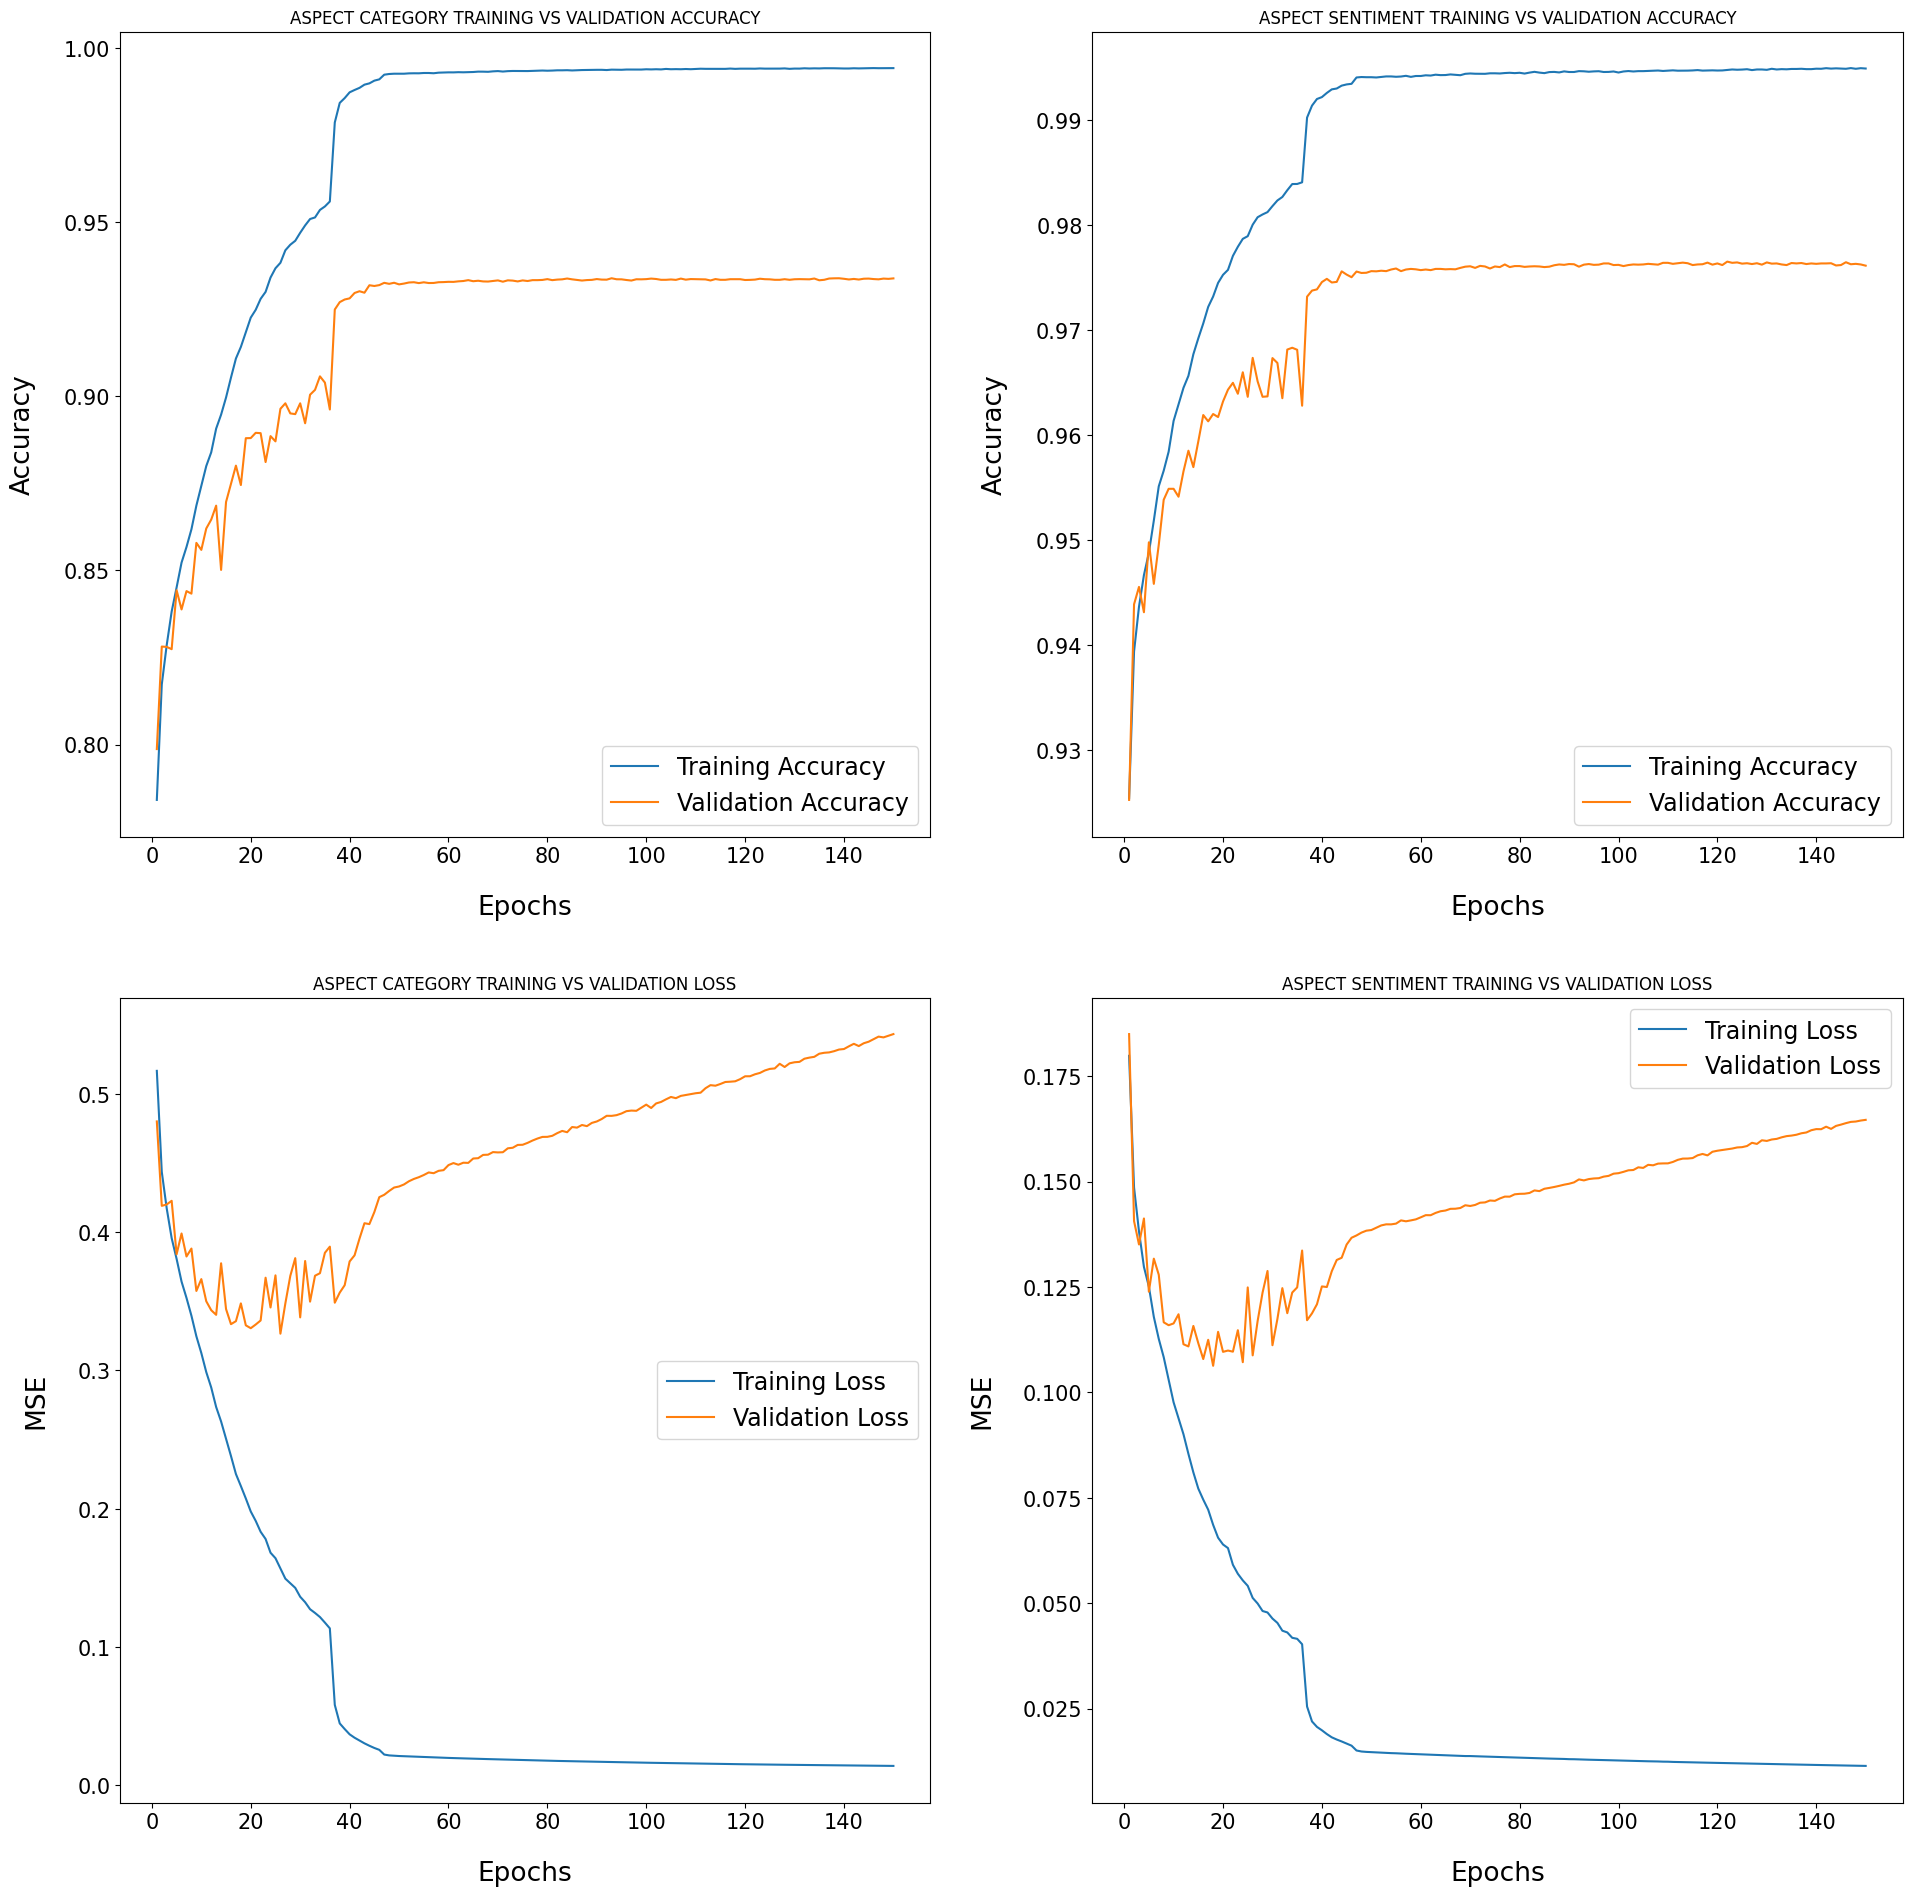

In [ ]:
metrics = history.history['loss']
epochs_range = range(1, len(metrics) + 1)

plt.figure(figsize=(23, 23))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, category_acc, label='Training Accuracy')
plt.plot(epochs_range, val_category_acc, label='Validation Accuracy')
plt.title('ASPECT CATEGORY TRAINING VS VALIDATION ACCURACY')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15, )
plt.legend(fontsize=17, loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, polarity_acc, label='Training Accuracy')
plt.plot(epochs_range, val_polarity_acc, label='Validation Accuracy')
plt.title('ASPECT SENTIMENT TRAINING VS VALIDATION ACCURACY')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17, loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(epochs_range,category_loss, label='Training Loss')
plt.plot(epochs_range, val_category_loss, label='Validation Loss')
plt.title('ASPECT CATEGORY TRAINING VS VALIDATION LOSS')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('MSE', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17)

plt.subplot(2, 2, 4)
plt.plot(epochs_range,polarity_loss, label='Training Loss')
plt.plot(epochs_range, val_polarity_loss, label='Validation Loss')
plt.title('ASPECT SENTIMENT TRAINING VS VALIDATION LOSS')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('MSE', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17)


plt.show()




### **MODEL1.** VALIDATION


In [ ]:
categories = y_train.columns[:3]
polarity_labels = ['POSITIVE', 'NEGATIVE']

In [ ]:
# ASPECT CATEGORY
y_pred_aspect = model.predict(test_embeds)
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]

y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_test[aspect_cat].values, axis=1)


1620/1620 [==============================] - 5s 2ms/step


In [ ]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_aspect_idx)
cm_polarity = cm(y_test.polarity.values, y_pred_polarity)

In [ ]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect_cat, aspect_acc):
    print('',cat,"\t",round(acc, 3))

# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE ACCURACY : **** 

CLASS	ACCURACY
 Accessibility 	 0.903
 Contribution 	 0.948
 Experimentation 	 0.951


*** POLARITY ACCURACY : **** 

CLASS		ACCURACY
POSITIVE 	 0.977
NEGATIVE 	 0.976


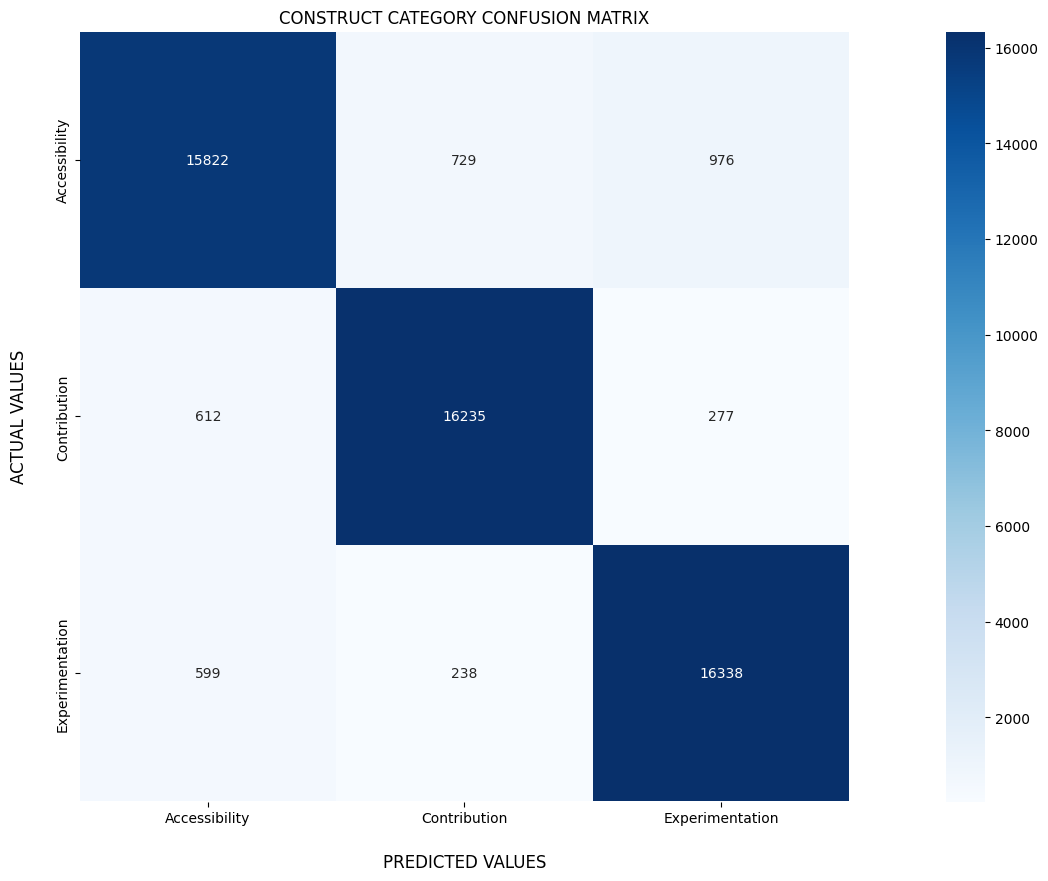

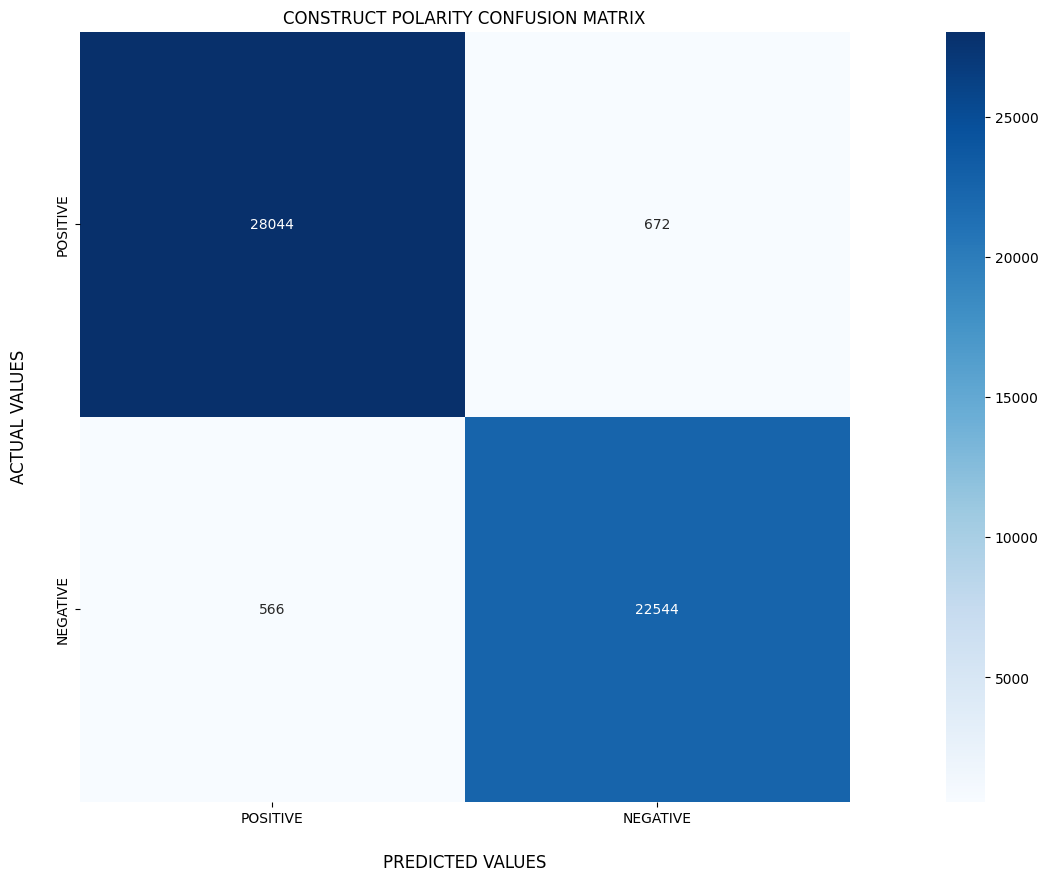

In [ ]:

plt.figure(figsize=(25, 10))

sns.heatmap(cm_aspect, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=categories, xticklabels=categories)
plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('CONSTRUCT CATEGORY CONFUSION MATRIX')
plt.savefig(path_data+'/'+"CM_ACC_CON_EXP.png")
plt.show()
plt.close()
plt.figure(figsize=(25, 10))
sns.heatmap(cm_polarity, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=polarity_labels, xticklabels=polarity_labels)
plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('CONSTRUCT POLARITY CONFUSION MATRIX')
plt.savefig(path_data+'/CM_POLARITY_ACC_CON_EXP.png')
plt.show()
plt.close()

In [ ]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
print(classification_report(y_test_idx, y_pred_aspect_idx, target_names=categories))
print('\n\n',classification_report(y_test.polarity.values, y_pred_polarity, target_names=polarity_labels))

                 precision    recall  f1-score   support

  Accessibility       0.93      0.90      0.92     17527
   Contribution       0.94      0.95      0.95     17124
Experimentation       0.93      0.95      0.94     17175

       accuracy                           0.93     51826
      macro avg       0.93      0.93      0.93     51826
   weighted avg       0.93      0.93      0.93     51826



               precision    recall  f1-score   support

    POSITIVE       0.98      0.98      0.98     28716
    NEGATIVE       0.97      0.98      0.97     23110

    accuracy                           0.98     51826
   macro avg       0.98      0.98      0.98     51826
weighted avg       0.98      0.98      0.98     51826



## **INFERENCE MODEL**

In [ ]:
def predictPreprocess(model, sent):
  outputs = sent2embed(model, sent)
  pred_X = np.array([outputs[1].detach().numpy()[0]])
  embed_X = tf.stack(pred_X)
  return embed_X

In [ ]:
def inferenceModel(multi_model, embed_model, sent,labels):
    #labels = y_train.columns[:-1]

    sents= sent.split('.')[:-1]
    results =[]
    for s in sents:
        test_embed = predictPreprocess(embed_model, s.strip()).numpy()
        test_embed=np.expand_dims(test_embed, axis=0)
        print(test_embed.shape)
        category_probab = multi_model.predict([test_embed])
        category_label_idx = np.argmax(category_probab[0])
        category_polarity = 1 if category_probab[1][0][0] > 0.5 else 0
        category_label = 'POS' if category_probab[1][0][0] > 0.5 else 'NEG'
        results.append([labels[category_label_idx] , category_polarity, category_label])

    return results


In [ ]:
SAVE_PATH=path_data+'/ConAccExp-Model.h5'
LOAD_PATH = SAVE_PATH
model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})
# SAMPLE 1
sent = '''This paper presents a model-free policy gradient approach for reinforcement learning that combines on-policy
updates with an off-policy critic . The hope is to learn continuous control in a sample-efficient fashion . The approach
is validated on a number of low-dimensional continuous control tasks in a simulated environment .'''
op = inferenceModel(model,embed_model, sent,aspect_cat)

print('PREDICTED OUTPUT :', op)

(1, 1, 768)
1/1 [==============================] - 2s 2s/step
(1, 1, 768)
1/1 [==============================] - 0s 24ms/step
(1, 1, 768)
1/1 [==============================] - 0s 23ms/step
PREDICTED OUTPUT : [['Contribution', 1, 'POS'], ['Contribution', 1, 'POS'], ['Experimentation', 1, 'POS']]


In [ ]:
# SAMPLE 2
sent = '''However , since the processing of sequential data seems to be a broad and general area of application , it is
conceivable that this work will be useful in the design and application of future CNNs . All in all , this paper introduces
an interesting idea to address an important topic .'''
op = inferenceModel(model,embed_model, sent,aspect_cat)

print('PREDICTED OUTPUT :', op)

(1, 1, 768)
1/1 [==============================] - 0s 21ms/step
(1, 1, 768)
1/1 [==============================] - 0s 22ms/step
PREDICTED OUTPUT : [['Contribution', 1, 'POS'], ['Contribution', 1, 'POS']]


## Model 2
The aim now is with the model training to classify Accessibility, Contribution and Experimentation with polarity extend this model to classify MOT, ORI; SUB, SOUN, CMP and CLA with polarity.

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_1 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_7 (Attention)     (None, 512)                  513       ['repeat_vector_1[0][0]'

In [ ]:
# LOAD MODEL
from keras.models import load_model
LOAD_PATH=path_data+'/ConAccExp-Model.h5'
model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})
repeat_op2 = RepeatVector(1,name="Model2_Rep")(model.get_layer('BEFORE_BRANCH').output)

attentions2=[]
for i in range(NUM_OF_ASPECTS_ORI):
  name = "Model2_Att"+str(i)
  x = Attention(return_sequences=False,name=name)(repeat_op2)
  attentions2.append(x)
#concatena all the outputs
concate_attention2  = Concatenate(name='BEFORE_BRANCH2')(attentions2)
flatten = Flatten()(concate_attention2)

# BRANCH 1: classify MOT,ORI;CLA;SOU;SUB,CMP
b1_x21 =  Dense(1000, activation='relu', name='CATEGORY_DENSE21')(flatten) #esta se quita en la version original (0.89,0.976)

category_output2 = Dense(NUM_OF_ASPECTS_ORI, activation='softmax', name='CATEGORY_OUTPUT2')(b1_x21)

# BRANCH 2 classify Polarity
dense2 =  Dense(60, activation='relu', name='SENTIMENT_DENSE2')(flatten)
polarity_output = Dense(1, activation='sigmoid', name='SENTIMENT_OUTPUT2')(dense2)

multitask_model2 = Model(inputs=model.input, outputs=[category_output2, polarity_output])
for l in multitask_model2.layers[:7]:
  l.trainable=False
multitask_model2.summary()



Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_2 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_13 (Attention)    (None, 512)                  513       ['repeat_vector_2[0][0]

In [ ]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT2': 'categorical_crossentropy',
         'SENTIMENT_OUTPUT2': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT2': 1.0,
                 'SENTIMENT_OUTPUT2': 1.0
              }


multitask_model2.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam',
                        metrics=['accuracy'])


multitask_model2.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_2 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_13 (Attention)    (None, 512)                  513       ['repeat_vector_2[0][0]

In [ ]:

construct_aspect=list(aspect_cat)+aspect

history = multitask_model2.fit(
                          train_embeds,
                          y =  {
                          'CATEGORY_OUTPUT2': y_train[aspect].values,
                          'SENTIMENT_OUTPUT2': y_train.polarity.values
                          },
                           validation_data = (test_embeds, {
                          'CATEGORY_OUTPUT2': y_test[aspect].values,
                          'SENTIMENT_OUTPUT2': y_test.polarity.values
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                          batch_size=64,
                          callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/ConAccExp-Model_C_O_M_S_S_CM.h5'

multitask_model2.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/150
1890/1890 - 26s - loss: 0.6919 - CATEGORY_OUTPUT2_loss: 0.6235 - SENTIMENT_OUTPUT2_loss: 0.0684 - CATEGORY_OUTPUT2_accuracy: 0.7592 - SENTIMENT_OUTPUT2_accuracy: 0.9728 - val_loss: 0.7589 - val_CATEGORY_OUTPUT2_loss: 0.6505 - val_SENTIMENT_OUTPUT2_loss: 0.1084 - val_CATEGORY_OUTPUT2_accuracy: 0.7643 - val_SENTIMENT_OUTPUT2_accuracy: 0.9662 - lr: 0.0010 - 26s/epoch - 14ms/step
Epoch 2/150
1890/1890 - 17s - loss: 0.5361 - CATEGORY_OUTPUT2_loss: 0.4938 - SENTIMENT_OUTPUT2_loss: 0.0422 - CATEGORY_OUTPUT2_accuracy: 0.8112 - SENTIMENT_OUTPUT2_accuracy: 0.9830 - val_loss: 0.7174 - val_CATEGORY_OUTPUT2_loss: 0.6021 - val_SENTIMENT_OUTPUT2_loss: 0.1153 - val_CATEGORY_OUTPUT2_accuracy: 0.7920 - val_SENTIMENT_OUTPUT2_accuracy: 0.9699 - lr: 0.0010 - 17s/epoch - 9ms/step
Epoch 3/150
1890/1890 - 17s - loss: 0.4339 - CATEGORY_OUTPUT2_loss: 0.4010 - SENTIMENT_OUTPUT2_loss: 0.0329 - CATEGORY_OUTPUT2_accuracy: 0.8478 - SENTIMENT_OUTPUT2_accuracy: 0.9866 - val_loss: 0.7026 - val_CATEGORY_OUTP

KeyboardInterrupt: 

### Fine Tuning. We unfrozen all layers and we train the whole model

In [ ]:
from keras.models import load_model
LOAD_PATH=path_data+'/ConAccExp-Model_C_O_M_S_S_CM.h5'
model2 = load_model(LOAD_PATH, custom_objects={'Attention': Attention})
for l in model2.layers[:7]:
  l.trainable=True
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_1 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_7 (Attention)     (None, 512)                  513       ['repeat_vector_1[0][0]'

In [ ]:
from keras import optimizers
metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

loss = { 'CATEGORY_OUTPUT2': 'categorical_crossentropy',
         'SENTIMENT_OUTPUT2': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT2': 1.0,
                 'SENTIMENT_OUTPUT2': 1.0
              }


model2.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer=optimizers.Adam(lr=0.000001),
                        metrics=['accuracy'])


model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_1 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_7 (Attention)     (None, 512)                  513       ['repeat_vector_1[0][0]'

In [ ]:
EPOCHS_FT=50
history = model2.fit(
                          train_embeds,
                          y =  {
                          'CATEGORY_OUTPUT2': y_train[aspect].values,
                          'SENTIMENT_OUTPUT2': y_train.polarity.values
                          },
                           validation_data = (test_embeds, {
                          'CATEGORY_OUTPUT2': y_test[aspect].values,
                          'SENTIMENT_OUTPUT2': y_test.polarity.values
                           }),
                           epochs = EPOCHS_FT,
                           shuffle=True,
                           verbose=2,
                          batch_size=64,


                          )
SAVE_PATH=path_data+'/ConAccExp-Model_C_O_M_S_S_CM_Fine_Tuning.h5'

model2.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/50
1890/1890 - 26s - loss: 0.5005 - CATEGORY_OUTPUT2_loss: 0.4403 - SENTIMENT_OUTPUT2_loss: 0.0603 - CATEGORY_OUTPUT2_accuracy: 0.8596 - SENTIMENT_OUTPUT2_accuracy: 0.9786 - val_loss: 0.9426 - val_CATEGORY_OUTPUT2_loss: 0.7867 - val_SENTIMENT_OUTPUT2_loss: 0.1560 - val_CATEGORY_OUTPUT2_accuracy: 0.7991 - val_SENTIMENT_OUTPUT2_accuracy: 0.9644 - 26s/epoch - 14ms/step
Epoch 2/50
1890/1890 - 21s - loss: 0.4242 - CATEGORY_OUTPUT2_loss: 0.3732 - SENTIMENT_OUTPUT2_loss: 0.0510 - CATEGORY_OUTPUT2_accuracy: 0.8702 - SENTIMENT_OUTPUT2_accuracy: 0.9805 - val_loss: 0.9169 - val_CATEGORY_OUTPUT2_loss: 0.7753 - val_SENTIMENT_OUTPUT2_loss: 0.1416 - val_CATEGORY_OUTPUT2_accuracy: 0.8084 - val_SENTIMENT_OUTPUT2_accuracy: 0.9652 - 21s/epoch - 11ms/step
Epoch 3/50
1890/1890 - 19s - loss: 0.4057 - CATEGORY_OUTPUT2_loss: 0.3553 - SENTIMENT_OUTPUT2_loss: 0.0504 - CATEGORY_OUTPUT2_accuracy: 0.8744 - SENTIMENT_OUTPUT2_accuracy: 0.9801 - val_loss: 0.8614 - val_CATEGORY_OUTPUT2_loss: 0.7277 - val_SENTI

### Model 2: Analysis and Validation

### **VALIDATION**

In [ ]:
categories = y_train.columns[4:]
print(categories)
polarity_labels = ['POSITIVE', 'NEGATIVE']

Index(['CLA', 'SOU', 'MOT', 'ORI', 'CMP', 'SUB'], dtype='object')


In [ ]:
# ASPECT CATEGORY
y_pred_aspect = model2.predict(test_embeds)
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]

y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_test[aspect].values, axis=1)


1620/1620 [==============================] - 5s 3ms/step


In [ ]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_aspect_idx)
cm_polarity = cm(y_test.polarity.values, y_pred_polarity)

In [ ]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect, aspect_acc):
    print('',cat,"\t",round(acc, 3))

# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE ACCURACY : **** 

CLASS	ACCURACY
 CLA 	 0.909
 SOU 	 0.809
 MOT 	 0.911
 ORI 	 0.896
 CMP 	 0.951
 SUB 	 0.895


*** POLARITY ACCURACY : **** 

CLASS		ACCURACY
POSITIVE 	 0.976
NEGATIVE 	 0.976


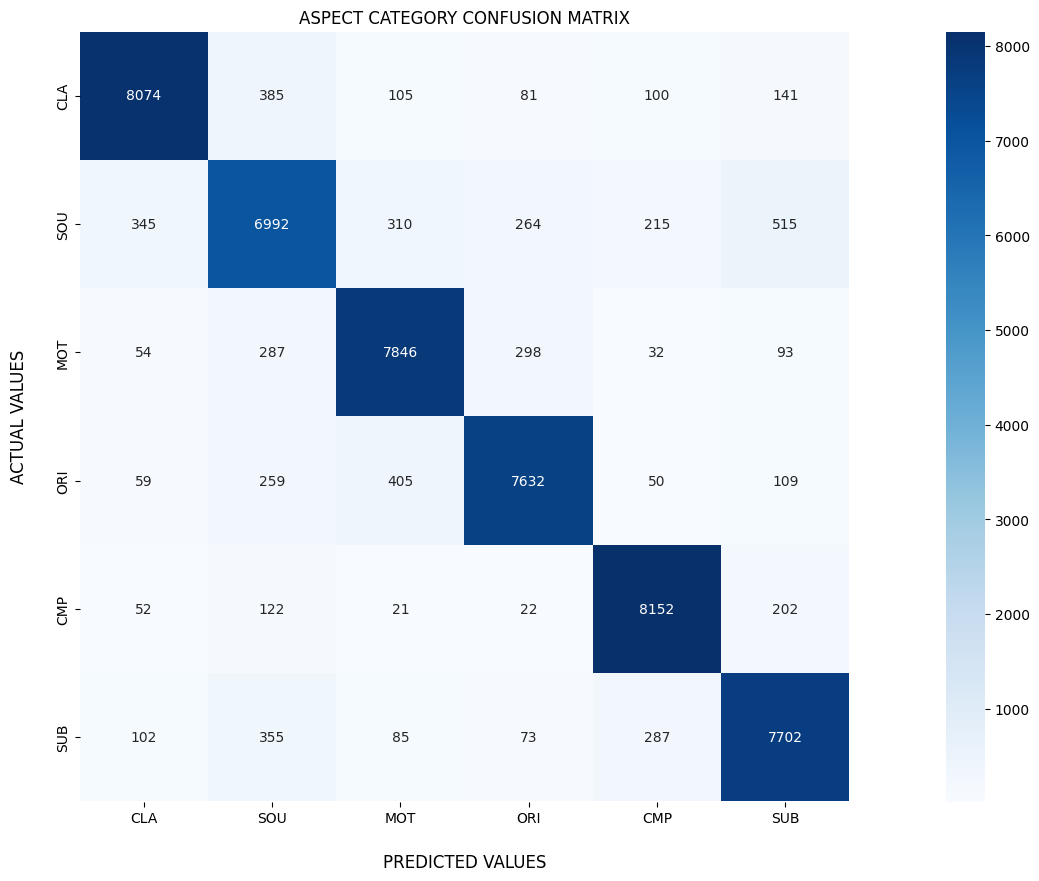

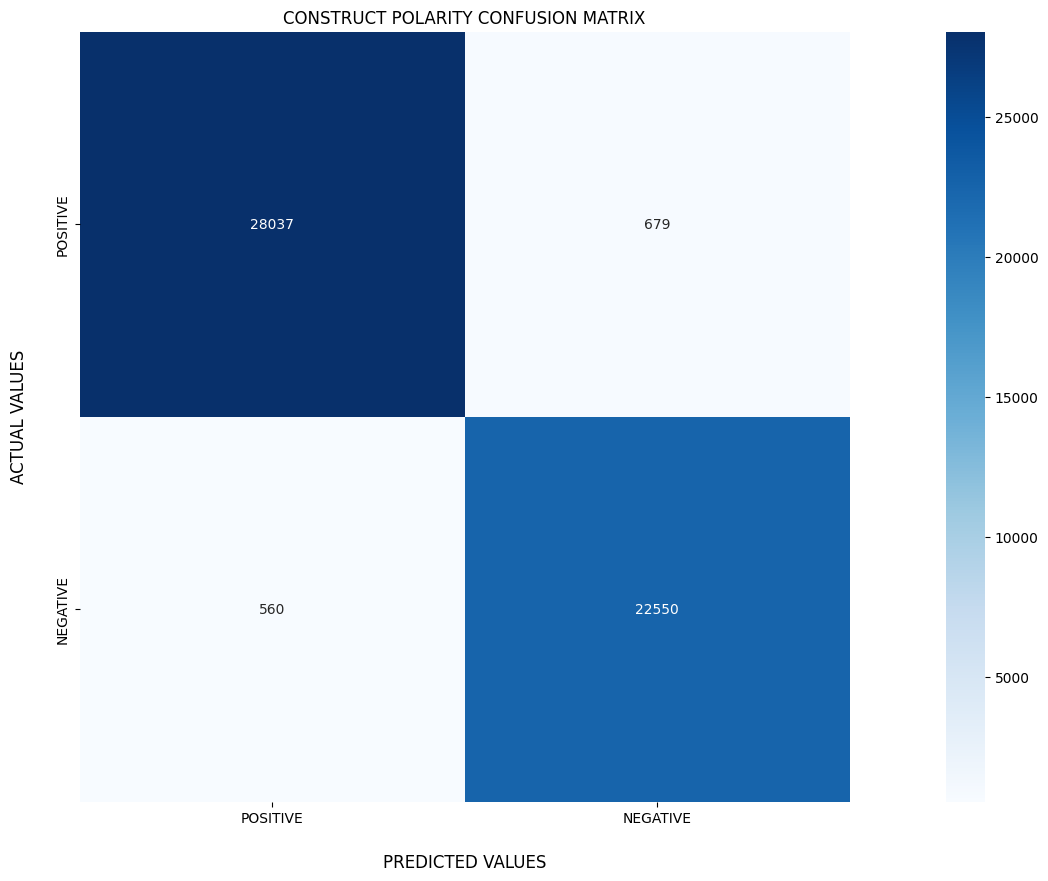

In [ ]:

plt.figure(figsize=(25, 10))

sns.heatmap(cm_aspect, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=categories, xticklabels=categories)
plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('ASPECT CATEGORY CONFUSION MATRIX')
plt.savefig(path_data+'/'+"CM_ASPECT.png")
plt.show()
plt.close()
plt.figure(figsize=(25, 10))
sns.heatmap(cm_polarity, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=polarity_labels, xticklabels=polarity_labels)
plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('CONSTRUCT POLARITY CONFUSION MATRIX')
plt.savefig(path_data+'/CM_POLARITY_ASPECT.png')
plt.show()
plt.close()

In [ ]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
print(classification_report(y_test_idx, y_pred_aspect_idx, target_names=categories))
print('\n\n',classification_report(y_test.polarity.values, y_pred_polarity, target_names=polarity_labels))

              precision    recall  f1-score   support

         CLA       0.93      0.91      0.92      8886
         SOU       0.83      0.81      0.82      8641
         MOT       0.89      0.91      0.90      8610
         ORI       0.91      0.90      0.90      8514
         CMP       0.92      0.95      0.94      8571
         SUB       0.88      0.90      0.89      8604

    accuracy                           0.90     51826
   macro avg       0.89      0.90      0.90     51826
weighted avg       0.90      0.90      0.90     51826



               precision    recall  f1-score   support

    POSITIVE       0.98      0.98      0.98     28716
    NEGATIVE       0.97      0.98      0.97     23110

    accuracy                           0.98     51826
   macro avg       0.98      0.98      0.98     51826
weighted avg       0.98      0.98      0.98     51826



## Model 2 Inference

In [ ]:
# SAMPLE 1
sent = '''This paper presents a model-free policy gradient approach for reinforcement learning that combines on-policy
updates with an off-policy critic . The hope is to learn continuous control in a sample-efficient fashion . The approach
is validated on a number of low-dimensional continuous control tasks in a simulated environment .'''
op = inferenceModel(model2,embed_model, sent,aspect)

print('PREDICTED OUTPUT :', op)

(1, 1, 768)
1/1 [==============================] - 0s 22ms/step
(1, 1, 768)
1/1 [==============================] - 0s 24ms/step
(1, 1, 768)
1/1 [==============================] - 0s 32ms/step
PREDICTED OUTPUT : [['ORI', 1, 'POS'], ['MOT', 1, 'POS'], ['SUB', 1, 'POS']]


In [ ]:
# SAMPLE 2
sent = '''However , since the processing of sequential data seems to be a broad and general area of application , it is
conceivable that this work will be useful in the design and application of future CNNs . All in all , this paper introduces
an interesting idea to address an important topic .'''
op = inferenceModel(model2,embed_model, sent,aspect)

print('PREDICTED OUTPUT :', op)

(1, 1, 768)
1/1 [==============================] - 0s 21ms/step
(1, 1, 768)
1/1 [==============================] - 0s 21ms/step
PREDICTED OUTPUT : [['MOT', 1, 'POS'], ['MOT', 1, 'POS']]


#MODEL 3: Three Branch Construct, Aspect and Polarity

In [ ]:
# LOAD MODEL
from keras.models import load_model
LOAD_PATH=path_data+'/ConAccExp-Model.h5'
model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})
repeat_op2 = RepeatVector(1)(model.get_layer('BEFORE_BRANCH').output)
attentions2=[]
#for i in range(NUM_OF_ASPECTS_ORI):
for i in range(0,2):
  name = "Model3_Att"+str(i)
  x = Attention(return_sequences=False,name=name)(repeat_op2)
  attentions2.append(x)
#concatena all the outputs
concate_attention2  = Concatenate(name='BEFORE_BRANCH2')(attentions2)
flatten = Flatten(name="Faltten1")(concate_attention2)

# BRANCH 1: classify MOT,ORI;CLA;SOU;SUB,CMP
b1_x21 =  Dense(1000, activation='relu', name='CATEGORY_DENSE21')(flatten) #esta se quita en la version original (0.89,0.976)

category_output3 = Dense(NUM_OF_ASPECTS_ORI, activation='softmax', name='CATEGORY_OUTPUT3')(b1_x21)

# BRANCH 2 classify Polarity
dense2 =  Dense(60, activation='relu', name='SENTIMENT_DENSE3')(flatten)
polarity_output3 = Dense(1, activation='sigmoid', name='SENTIMENT_OUTPUT3')(dense2)

# BRANCH 3 classify construct
fla = Flatten(name="Fla")(model.get_layer('BEFORE_BRANCH').output)

construct_output = Dense(NUM_OF_CONSTRUCTS, activation='softmax', name='CONSTRUCT_OUTPUT3')(fla)



multitask_model3 = Model(inputs=model.input, outputs=[category_output3, polarity_output3,construct_output])
for l in multitask_model3.layers[:7]:
  l.trainable=False
multitask_model3.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_2 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_13 (Attention)    (None, 512)                  513       ['repeat_vector_2[0][0]'

In [ ]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT3': 'categorical_crossentropy',
         'CONSTRUCT_OUTPUT3':'categorical_crossentropy',
         'SENTIMENT_OUTPUT3': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT3': 1.0,
               'CONSTRUCT_OUTPUT3':1.0,
                'SENTIMENT_OUTPUT3': 1.0
              }


multitask_model3.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam',
                        metrics=['accuracy'])


multitask_model3.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_2 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_13 (Attention)    (None, 512)                  513       ['repeat_vector_2[0][0]'

In [ ]:
history = multitask_model3.fit(
                          train_embeds,
                          y =  {
                          'CATEGORY_OUTPUT3': y_train[aspect].values,
                          'CONSTRUCT_OUTPUT3':y_train[aspect_cat].values,
                          'SENTIMENT_OUTPUT3': y_train.polarity.values

                          },
                           validation_data = (test_embeds, {
                          'CATEGORY_OUTPUT3': y_test[aspect].values,
                          'CONSTRUCT_OUTPUT3':y_test[aspect_cat].values,
                          'SENTIMENT_OUTPUT3': y_test.polarity.values
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                          batch_size=64,
                          callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/Aspect_Polarity_Construct.h5'

multitask_model3.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/150
1890/1890 - 18s - loss: 1.0046 - CATEGORY_OUTPUT3_loss: 0.6018 - SENTIMENT_OUTPUT3_loss: 0.0686 - CONSTRUCT_OUTPUT3_loss: 0.3342 - CATEGORY_OUTPUT3_accuracy: 0.7651 - SENTIMENT_OUTPUT3_accuracy: 0.9722 - CONSTRUCT_OUTPUT3_accuracy: 0.8718 - val_loss: 1.1232 - val_CATEGORY_OUTPUT3_loss: 0.6517 - val_SENTIMENT_OUTPUT3_loss: 0.1063 - val_CONSTRUCT_OUTPUT3_loss: 0.3652 - val_CATEGORY_OUTPUT3_accuracy: 0.7645 - val_SENTIMENT_OUTPUT3_accuracy: 0.9667 - val_CONSTRUCT_OUTPUT3_accuracy: 0.8549 - lr: 0.0010 - 18s/epoch - 10ms/step
Epoch 2/150
1890/1890 - 13s - loss: 0.8124 - CATEGORY_OUTPUT3_loss: 0.4772 - SENTIMENT_OUTPUT3_loss: 0.0434 - CONSTRUCT_OUTPUT3_loss: 0.2918 - CATEGORY_OUTPUT3_accuracy: 0.8167 - SENTIMENT_OUTPUT3_accuracy: 0.9826 - CONSTRUCT_OUTPUT3_accuracy: 0.8850 - val_loss: 1.0747 - val_CATEGORY_OUTPUT3_loss: 0.6000 - val_SENTIMENT_OUTPUT3_loss: 0.1131 - val_CONSTRUCT_OUTPUT3_loss: 0.3616 - val_CATEGORY_OUTPUT3_accuracy: 0.7968 - val_SENTIMENT_OUTPUT3_accuracy: 0.9694 

KeyboardInterrupt: 

# COMPARISON: BASE MODEL

In [ ]:
#MODEL BASE classify aspect+polarity
#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)

#for every aspect in (Accessibility, Contribution, Experimentation) add an attention layer
attentions=[]
for i in range(NUM_OF_ASPECTS_ORI):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)
flatten = Flatten()(concate_attention)

# BRANCH 1: classify Accessibility, Contribution and Experimentation
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(NUM_OF_ASPECTS_ORI, activation='softmax', name='CATEGORY_OUTPUT_base')(b1_x)

# BRANCH 2 classify Polarity
dense2 =  Dense(60, activation='relu', name='SENTIMENT_DENSE')(flatten)
polarity_output = Dense(1, activation='sigmoid', name='SENTIMENT_OUTPUT_base')(dense2)

multitask_model_base = Model(inputs=embed, outputs=[category_output, polarity_output])


In [ ]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT_base': 'categorical_crossentropy',
         'SENTIMENT_OUTPUT_base': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT_base': 1.0,
                 'SENTIMENT_OUTPUT_base': 1.0
              }


multitask_model_base.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam',
                        metrics=['accuracy'])


multitask_model_base.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_4 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_44 (Attention)    (None, 512)                  513       ['repeat_vector_4[0][0]'

In [ ]:
history = multitask_model_base.fit(
                          train_embeds,
                          y =  {
                          'CATEGORY_OUTPUT_base': y_train[aspect].values,
                          'SENTIMENT_OUTPUT_base': y_train.polarity.values

                          },
                           validation_data = (test_embeds, {
                          'CATEGORY_OUTPUT_base': y_test[aspect].values,
                          'SENTIMENT_OUTPUT_base': y_test.polarity.values
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                          batch_size=64,
                          callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/Aspect_Polarity_base.h5'

multitask_model_base.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/150
1890/1890 - 24s - loss: 1.0377 - CATEGORY_OUTPUT_base_loss: 0.8555 - SENTIMENT_OUTPUT_base_loss: 0.1822 - CATEGORY_OUTPUT_base_accuracy: 0.6793 - SENTIMENT_OUTPUT_base_accuracy: 0.9256 - val_loss: 0.9113 - val_CATEGORY_OUTPUT_base_loss: 0.7510 - val_SENTIMENT_OUTPUT_base_loss: 0.1602 - val_CATEGORY_OUTPUT_base_accuracy: 0.7245 - val_SENTIMENT_OUTPUT_base_accuracy: 0.9319 - lr: 0.0010 - 24s/epoch - 12ms/step
Epoch 2/150
1890/1890 - 16s - loss: 0.8728 - CATEGORY_OUTPUT_base_loss: 0.7247 - SENTIMENT_OUTPUT_base_loss: 0.1481 - CATEGORY_OUTPUT_base_accuracy: 0.7314 - SENTIMENT_OUTPUT_base_accuracy: 0.9390 - val_loss: 0.8930 - val_CATEGORY_OUTPUT_base_loss: 0.7515 - val_SENTIMENT_OUTPUT_base_loss: 0.1416 - val_CATEGORY_OUTPUT_base_accuracy: 0.7173 - val_SENTIMENT_OUTPUT_base_accuracy: 0.9411 - lr: 0.0010 - 16s/epoch - 8ms/step
Epoch 3/150
1890/1890 - 16s - loss: 0.8186 - CATEGORY_OUTPUT_base_loss: 0.6813 - SENTIMENT_OUTPUT_base_loss: 0.1373 - CATEGORY_OUTPUT_base_accuracy: 0.7475

In [ ]:
# ASPECT CATEGORY
y_pred_aspect = multitask_model_base.predict(test_embeds)
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]

y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_test[aspect].values, axis=1)


1620/1620 [==============================] - 5s 3ms/step


In [ ]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_aspect_idx)
cm_polarity = cm(y_test.polarity.values, y_pred_polarity)

In [ ]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect, aspect_acc):
    print('',cat,"\t",round(acc, 3))

# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE ACCURACY : **** 

CLASS	ACCURACY
 CLA 	 0.918
 SOU 	 0.821
 MOT 	 0.919
 ORI 	 0.915
 CMP 	 0.955
 SUB 	 0.903


*** POLARITY ACCURACY : **** 

CLASS		ACCURACY
POSITIVE 	 0.976
NEGATIVE 	 0.975


In [ ]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
import keras
print(classification_report(y_test_idx,  y_pred_aspect_idx, target_names=aspect))
print('\n\n',classification_report(y_test.polarity.values, y_pred_polarity, target_names=polarity_labels))


              precision    recall  f1-score   support

         CLA       0.94      0.92      0.93      8886
         SOU       0.85      0.82      0.83      8641
         MOT       0.90      0.92      0.91      8610
         ORI       0.92      0.92      0.92      8514
         CMP       0.93      0.95      0.94      8571
         SUB       0.89      0.90      0.89      8604

    accuracy                           0.91     51826
   macro avg       0.90      0.91      0.90     51826
weighted avg       0.90      0.91      0.90     51826



               precision    recall  f1-score   support

    POSITIVE       0.98      0.98      0.98     28716
    NEGATIVE       0.97      0.97      0.97     23110

    accuracy                           0.98     51826
   macro avg       0.97      0.98      0.98     51826
weighted avg       0.98      0.98      0.98     51826



In [ ]:
#Test if the base model make a pos the construct category the error make
LOAD_PATH =path_data+'/Aspect_Polarity_base.h5'

multitask_model_base = load_model(LOAD_PATH, custom_objects={'Attention': Attention})
y_pred_aspect = multitask_model_base.predict(test_embeds)
y_pred_categories = y_pred_aspect[0]

y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]
y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_test[aspect].values, axis=1)
aciertos=0
for i in range(0,len(y_test_idx)):
  if int(y_test_idx[i]/2)==int(y_pred_aspect_idx[i]/2):
    aciertos+=1
print("ACC ",aciertos/len(y_test_idx))


1620/1620 [==============================] - 6s 3ms/step
[[7.7176594e-08 9.8827899e-01 8.3489491e-16 9.6502731e-07 1.0969746e-13
  1.1719913e-02]
 [1.9694964e-12 2.9040185e-11 9.6138262e-12 1.6372347e-13 3.8481097e-11
  1.0000000e+00]
 [8.2095851e-19 3.8867763e-11 3.9126360e-16 1.9765835e-07 9.9999976e-01
  7.3222255e-09]
 ...
 [1.0128748e-08 7.9820549e-01 7.5643840e-08 4.3585919e-06 4.3694854e-05
  2.0174639e-01]
 [7.1361607e-01 3.2658398e-02 5.6325484e-02 1.3542037e-01 2.1902366e-02
  4.0077377e-02]
 [5.5367468e-07 2.1819197e-07 2.7680567e-06 3.8362295e-08 9.9999630e-01
  1.1763438e-07]]


In [ ]:
print(aspect)

['CLA', 'SOU', 'MOT', 'ORI', 'CMP', 'SUB']


###*Specific Aspect Construct Model*
 In this case we training machine for every construct. Thus, we can distinguish between the aspect with a construct.

####Preprocessig Data : Accessibility

In [ ]:
#select only data with accessibility label
#get the index
print(train_data.head())
train_acce= train_data.query("Accessibility==1")
test_acce= test_data.query("Accessibility==1")
train_index_pos = dict({r:pos for pos,r in enumerate(train_data.index)})
test_index_pos = dict({r:pos for pos,r in enumerate(test_data.index)})
print(train_embeds.shape)
train_embd_acce =[]
for k in train_acce.index:
  train_embd_acce.append(train_embeds[train_index_pos[k],:,:])

train_embd_acce = np.array(train_embd_acce)
print(train_embd_acce.shape)

test_embd_acce =[]
for k in test_acce.index:
  test_embd_acce.append(test_embeds[test_index_pos[k],:,:])

test_embd_acce = np.array(test_embd_acce)
print(test_embd_acce.shape)

y_train_acc=train_acce[train_acce.columns[1:]]
y_test_acc=test_acce[test_acce.columns[1:]]
y_train_acc['polarity']=y_train_acc['polarity'].where(y_train_acc['polarity']==1,0)
y_test_acc['polarity']=y_test_acc['polarity'].where(y_test_acc['polarity']==1,0)

#testear
#print(sci_embeds_train['y'][train_index_pos[train_acce.index[2]]])
#print(test_embd_acce.shape)

#testear
#print(sci_embeds_train['y'][train_index_pos[train_acce.index[2]]])
#print(train_acce.head())
print(train_acce.head())


                                                   review  Accessibility  \
164459  I think all these clarifications will increase...              1   
66724      I found the paper to be clear and well written              1   
133792  The writing and clarity of paper can be improv...              1   
85009   while this is an interesting result , it seems...              1   
119224  this algorithm is very similar to W-GAN and th...              0   

        Contribution  Experimentation  polarity  CLA  SOU  MOT  ORI  CMP  SUB  
164459             0                0        -1    1    0    0    0    0    0  
66724              0                0         1    1    0    0    0    0    0  
133792             0                0        -1    1    0    0    0    0    0  
85009              0                0        -1    0    1    0    0    0    0  
119224             1                0        -1    0    0    0    1    0    0  
(120926, 1, 768)
(40057, 1, 768)
(17527, 1, 768)
              

<ipython-input-11-7b48f247073e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_acc['polarity']=y_train_acc['polarity'].where(y_train_acc['polarity']==1,0)
<ipython-input-11-7b48f247073e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_acc['polarity']=y_test_acc['polarity'].where(y_test_acc['polarity']==1,0)


In [ ]:

#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)


attentions=[]
for i in range(0,2):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)
flatten = Flatten()(concate_attention)

b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(2, activation='softmax', name='CATEGORY_OUTPUT_acc')(b1_x)


model_acc = Model(inputs=embed, outputs=category_output)



In [ ]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT_acc': 'categorical_crossentropy',
       }



model_acc.compile(loss= loss,
                        optimizer='adam',
                        metrics=['accuracy'])


model_acc.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector (RepeatVecto  (None, 1, 512)               0         ['BILSTM[0][0]']              
 r)                                                                                               
                                                                                                  
 attention_1 (Attention)     (None, 512)                  513       ['repeat_vector[0][0]']   

In [ ]:
asp=['CLA','SOU']
history = model_acc.fit(
                          train_embd_acce,
                          y =  {
                          'CATEGORY_OUTPUT_acc': y_train_acc[asp].values,
                          },
                           validation_data = (test_embd_acce, {
                          'CATEGORY_OUTPUT_acc': y_test_acc[asp].values,
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                           batch_size=64,
                           callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/Accessibility_Aspects.h5'

model_acc.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

NameError: name 'model_acc' is not defined

### CONTRIBUTION

In [ ]:
#select only data with contribution label
#get the index
print(train_data.head())
train_con= train_data.query("Contribution==1")
test_con= test_data.query("Contribution==1")
train_index_pos = dict({r:pos for pos,r in enumerate(train_data.index)})
test_index_pos = dict({r:pos for pos,r in enumerate(test_data.index)})
print(train_embeds.shape)
train_embd_con =[]
for k in train_con.index:
#select only data with contribution label
#get the index
print(train_data.head())
train_con= train_data.query("Contribution==1")
test_con= test_data.query("Contribution==1")
train_index_pos = dict({r:pos for pos,r in enumerate(train_data.index)})
test_index_pos = dict({r:pos for pos,r in enumerate(test_data.index)})
print(train_embeds.shape)
train_embd_con =[]
for k in train_con.index:
  train_embd_con.append(train_embeds[train_index_pos[k],:,:])

train_embd_con = np.array(train_embd_con)
print(train_embd_con.shape)

test_embd_con =[]
for k in test_con.index:
  test_embd_con.append(test_embeds[test_index_pos[k],:,:])

test_embd_con = np.array(test_embd_con)
print(test_embd_con.shape)

y_train_con=train_con[train_con.columns[1:]]
y_test_con=test_con[test_con.columns[1:]]
y_train_con['polarity']=y_train_con['polarity'].where(y_train_con['polarity']==1,0)
y_test_con['polarity']=y_test_con['polarity'].where(y_test_con['polarity']==1,0)


print(train_con.head())


                                                   review  Accessibility  \
164459  I think all these clarifications will increase...              1   
66724      I found the paper to be clear and well written              1   
133792  The writing and clarity of paper can be improv...              1   
85009   while this is an interesting result , it seems...              1   
119224  this algorithm is very similar to W-GAN and th...              0   

        Contribution  Experimentation  polarity  CLA  SOU  MOT  ORI  CMP  SUB  
164459             0                0        -1    1    0    0    0    0    0  
66724              0                0         1    1    0    0    0    0    0  
133792             0                0        -1    1    0    0    0    0    0  
85009              0                0        -1    0    1    0    0    0    0  
119224             1                0        -1    0    0    0    1    0    0  
(120926, 1, 768)
(40460, 1, 768)
(17124, 1, 768)
              

<ipython-input-11-30b2de23fdca>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_con['polarity']=y_train_con['polarity'].where(y_train_con['polarity']==1,0)
<ipython-input-11-30b2de23fdca>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_con['polarity']=y_test_con['polarity'].where(y_test_con['polarity']==1,0)


In [ ]:

#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)


attentions=[]
for i in range(0,2):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)
flatten = Flatten()(concate_attention)
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(2, activation='softmax', name='CATEGORY_OUTPUT_con')(b1_x)


model_con = Model(inputs=embed, outputs=category_output)



In [ ]:
from keras.callbacks import ReduceLROnPlateau
metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT_con': 'categorical_crossentropy',
       }



model_con.compile(loss= loss,
                        optimizer='adam',
                        metrics=['accuracy'])
model_con.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_2 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_9 (Attention)     (None, 512)                  513       ['repeat_vector_2[0][0]'

In [ ]:
asp=['ORI','MOT']
history =model_con.fit(
                          train_embd_con,
                          y =  {
                          'CATEGORY_OUTPUT_con': y_train_con[asp].values,
                          },
                           validation_data = (test_embd_con, {
                          'CATEGORY_OUTPUT_con': y_test_con[asp].values,
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                           batch_size=64,
                           callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/Contribution_Aspects.h5'

model_con.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/150
633/633 - 9s - loss: 0.3735 - accuracy: 0.8291 - val_loss: 0.3253 - val_accuracy: 0.8531 - lr: 0.0010 - 9s/epoch - 14ms/step
Epoch 2/150
633/633 - 4s - loss: 0.3131 - accuracy: 0.8578 - val_loss: 0.2952 - val_accuracy: 0.8634 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 3/150
633/633 - 4s - loss: 0.2942 - accuracy: 0.8659 - val_loss: 0.2925 - val_accuracy: 0.8681 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 4/150
633/633 - 4s - loss: 0.2780 - accuracy: 0.8745 - val_loss: 0.3166 - val_accuracy: 0.8532 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 5/150
633/633 - 4s - loss: 0.2654 - accuracy: 0.8820 - val_loss: 0.2847 - val_accuracy: 0.8776 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 6/150
633/633 - 4s - loss: 0.2497 - accuracy: 0.8879 - val_loss: 0.2542 - val_accuracy: 0.8868 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 7/150
633/633 - 4s - loss: 0.2393 - accuracy: 0.8943 - val_loss: 0.2613 - val_accuracy: 0.8849 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 8/150
633/633 - 4s - loss: 0.2209 - accur

### EXPERIMENTATION

In [ ]:
#select only data with experimentatin label
#get the index
print(train_data.head())
train_exp= train_data.query("Experimentation==1")
test_exp= test_data.query("Experimentation==1")
train_index_pos = dict({r:pos for pos,r in enumerate(train_data.index)})
test_index_pos = dict({r:pos for pos,r in enumerate(test_data.index)})
print(train_embeds.shape)
train_embd_exp =[]
for k in train_exp.index:
  train_embd_exp.append(train_embeds[train_index_pos[k],:,:])

train_embd_exp = np.array(train_embd_exp)
print(train_embd_exp.shape)

test_embd_exp =[]
for k in test_exp.index:
  test_embd_exp.append(test_embeds[test_index_pos[k],:,:])

test_embd_exp = np.array(test_embd_exp)
print(test_embd_exp.shape)

y_train_exp=train_exp[train_exp.columns[1:]]
y_test_exp=test_exp[test_exp.columns[1:]]
y_train_exp['polarity']=y_train_exp['polarity'].where(y_train_exp['polarity']==1,0)
y_test_exp['polarity']=y_test_exp['polarity'].where(y_test_exp['polarity']==1,0)


print(train_exp.head())


                                                   review  Accessibility  \
164459  I think all these clarifications will increase...              1   
66724      I found the paper to be clear and well written              1   
133792  The writing and clarity of paper can be improv...              1   
85009   while this is an interesting result , it seems...              1   
119224  this algorithm is very similar to W-GAN and th...              0   

        Contribution  Experimentation  polarity  CLA  SOU  MOT  ORI  CMP  SUB  
164459             0                0        -1    1    0    0    0    0    0  
66724              0                0         1    1    0    0    0    0    0  
133792             0                0        -1    1    0    0    0    0    0  
85009              0                0        -1    0    1    0    0    0    0  
119224             1                0        -1    0    0    0    1    0    0  
(120926, 1, 768)
(40409, 1, 768)
(17175, 1, 768)
              

<ipython-input-23-ba7cfa72b3db>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_exp['polarity']=y_train_exp['polarity'].where(y_train_exp['polarity']==1,0)
<ipython-input-23-ba7cfa72b3db>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_exp['polarity']=y_test_exp['polarity'].where(y_test_exp['polarity']==1,0)


In [ ]:

#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)


attentions=[]
for i in range(0,2):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)
flatten = Flatten()(concate_attention)


b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(2, activation='softmax', name='CATEGORY_OUTPUT_exp')(b1_x)


model_exp = Model(inputs=embed, outputs=category_output)



In [ ]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT_exp': 'categorical_crossentropy',

       }

model_exp.compile(loss= loss,
                        optimizer='adam',
                        metrics=['accuracy'])


model_exp.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_3 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_13 (Attention)    (None, 512)                  513       ['repeat_vector_3[0][0]'

In [ ]:
asp=['SUB','CMP']
history =model_exp.fit(
                          train_embd_exp,
                          y =  {
                          'CATEGORY_OUTPUT_exp': y_train_exp[asp].values,
                          },
                           validation_data = (test_embd_exp, {
                          'CATEGORY_OUTPUT_exp': y_test_exp[asp].values,
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                           batch_size=64,
                           callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/Experimentation_Aspects.h5'

model_exp.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/150
632/632 - 9s - loss: 0.4049 - accuracy: 0.8152 - val_loss: 0.3510 - val_accuracy: 0.8480 - lr: 0.0010 - 9s/epoch - 14ms/step
Epoch 2/150
632/632 - 4s - loss: 0.3301 - accuracy: 0.8557 - val_loss: 0.3339 - val_accuracy: 0.8553 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 3/150
632/632 - 4s - loss: 0.2990 - accuracy: 0.8702 - val_loss: 0.2874 - val_accuracy: 0.8784 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 4/150
632/632 - 4s - loss: 0.2780 - accuracy: 0.8801 - val_loss: 0.2967 - val_accuracy: 0.8732 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 5/150
632/632 - 4s - loss: 0.2633 - accuracy: 0.8866 - val_loss: 0.2663 - val_accuracy: 0.8859 - lr: 0.0010 - 4s/epoch - 7ms/step
Epoch 6/150
632/632 - 4s - loss: 0.2439 - accuracy: 0.8982 - val_loss: 0.2897 - val_accuracy: 0.8810 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 7/150
632/632 - 4s - loss: 0.2267 - accuracy: 0.9072 - val_loss: 0.2520 - val_accuracy: 0.8974 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 8/150
632/632 - 4s - loss: 0.2129 - accur

### CONSTRUCT-CATEGORY ASPECT-CATEGORY and POLARITY

In [ ]:
from keras.models import load_model
#Load the different models
LOAD_PATH =path_data+'/ConAccExp-Model.h5'
model_Construct = load_model(LOAD_PATH, custom_objects={'Attention': Attention})
models_aspects=[]
LOAD_PATH=path_data+'/Accessibility_Aspects.h5'
models_aspects.append(load_model(LOAD_PATH, custom_objects={'Attention': Attention}))
LOAD_PATH=path_data+'/Contribution_Aspects.h5'
models_aspects.append(load_model(LOAD_PATH, custom_objects={'Attention': Attention}))
LOAD_PATH=path_data+'/Experimentation_Aspects.h5'
models_aspects.append(load_model(LOAD_PATH, custom_objects={'Attention': Attention}))

In [ ]:
aspect_cat= train_data.columns[1:4]
print(aspect)
print(aspect_cat)

['CLA', 'SOU', 'MOT', 'ORI', 'CMP', 'SUB']
Index(['Accessibility', 'Contribution', 'Experimentation'], dtype='object')


In [ ]:
# ASPECT CATEGORY
categories = y_train.columns[:3]
polarity_labels = ['POSITIVE', 'NEGATIVE']
aspects=['CLA','ORI','ORI','MOT','SUB','CMP']
ACC_cat=['CLA','SOU']
#dict_keys=[dict('CLA':0,'SOU':1),dict('ORI':3,'MOT':2),dic('SUB':5,'CMP':4)]
dict_keys=[dict({0:0,1:1}),dict({0:3,1:2}),dict({0:5,1:4})]
CON_cat=['ORI','MOT']
EXP_cat=['SUB','CMP']
#Tagger by Accessibility, Contribution and Experimentation. Also polarity
y_pred_aspect = model_Construct.predict(test_embeds)
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]
y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_test[aspect_cat].values, axis=1)


y_pred_final=np.zeros((len(test_embeds,)),dtype=int)
y_test_idx =np.argmax(y_test[aspect].values, axis=1)
cons_acc = [i for i in range(0,len(y_pred_aspect_idx)) if y_pred_aspect_idx[i]==0]
cons_con = [i for i in range(0,len(y_pred_aspect_idx)) if y_pred_aspect_idx[i]==1]
cons_exp = [i for i in range(0,len(y_pred_aspect_idx)) if y_pred_aspect_idx[i]==2]
#setences with accessibility
embds_acc=test_embeds[cons_acc]
#setences with contribution
embds_con=test_embeds[cons_con]
#setences with experimentation
embds_exp=test_embeds[cons_exp]

#ACCESSIBILITY-->CLA and SOU
sub_y_pred_categories=models_aspects[0].predict(embds_acc)
sub_y_pred_aspect_idx = np.argmax(sub_y_pred_categories, axis=1)
j=0
for i in cons_acc:
  y_pred_final[i]=dict_keys[0][sub_y_pred_aspect_idx[j]]
  j+=1

#CONTRIBUTION-->ORI and MOT
sub_y_pred_categories=models_aspects[1].predict(embds_con)
sub_y_pred_aspect_idx = np.argmax(sub_y_pred_categories, axis=1)
j=0
for i in cons_con:
  y_pred_final[i]=dict_keys[1][sub_y_pred_aspect_idx[j]]
  j+=1

#EXPERIMENTATION-->SUB and CMP
sub_y_pred_categories=models_aspects[2].predict(embds_exp)
sub_y_pred_aspect_idx = np.argmax(sub_y_pred_categories, axis=1)
j=0
for i in cons_exp:
  y_pred_final[i]=dict_keys[2][sub_y_pred_aspect_idx[j]]
  j+=1


550/550 [==============================] - 2s 2ms/step


In [ ]:
#Some Correct Examples
#Examples construct and aspect

pd.options.display.max_colwidth = 150
pos_acc_sou=np.argwhere(y_pred_final==1).reshape(-1)
pos_acc_sou_neg=[i for i in pos_acc_sou if y_pred_polarity[i]==0]
print("Sentences CON+NEG", len(pos_acc_sou_neg))
name_out = path_data+'/sen_acc_sou_neg.txt'
print("Writting ",name_out)
f=open(name_out,'wt')
for i in pos_acc_sou_neg:
  if (y_test_idx[i]== y_pred_final[i] and y_test.polarity.values[i]==y_pred_polarity[i]):
    f.write(test_data.loc[test_data.index[i],'review']+'\n')
f.close()

Sentences CON+NEG 4450
Writting  /content/gdrive/My Drive/Colab Notebooks/tesis_juanjo/Accesibilidad_Contribution_Reports/data/sen_acc_sou_neg.txt


In [ ]:
#Some Wrong Examples
#Examples construct and aspect

pd.options.display.max_colwidth = 150
pos_acc_cla=np.argwhere(y_pred_final==0).reshape(-1)
pos_acc_cla_pos=[i for i in pos_acc_cla if y_pred_polarity[i]==1]
print("Sentences CON+NEG", len(pos_acc_cla_pos))
name_out = path_data+'/sen_wrong_acc_cla_pos.txt'
print("Writting ",name_out)
f=open(name_out,'wt')
for i in pos_acc_cla_pos:
  if (y_test_idx[i]!= y_pred_final[i] or y_test.polarity.values[i]!=y_pred_polarity[i]):
    p=" POS"
    if (y_test.polarity.values[i]==0):
      p=" NEG"

    f.write(test_data.loc[test_data.index[i],'review']+"-->"+aspect[y_test_idx[i]]+p+'\n')
f.close()

Sentences CON+NEG 3919
Writting  /content/gdrive/My Drive/Colab Notebooks/tesis_juanjo/Accesibilidad_Contribution_Reports/data/sen_wrong_acc_cla_pos.txt


In [ ]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_final)
cm_polarity = cm(y_test.polarity.values, y_pred_polarity)

In [ ]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect, aspect_acc):
    print('',cat,"\t",round(acc, 3))

# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE ACCURACY : **** 

CLASS	ACCURACY
 CLA 	 0.916
 SOU 	 0.815
 MOT 	 0.919
 ORI 	 0.913
 CMP 	 0.957
 SUB 	 0.902


*** POLARITY ACCURACY : **** 

CLASS		ACCURACY
POSITIVE 	 0.977
NEGATIVE 	 0.976


In [ ]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
import keras
print(classification_report(y_test_idx, y_pred_final, target_names=aspect))
print('\n\n',classification_report(y_test.polarity.values, y_pred_polarity, target_names=polarity_labels))


              precision    recall  f1-score   support

         CLA       0.94      0.92      0.93      8886
         SOU       0.84      0.82      0.83      8641
         MOT       0.90      0.92      0.91      8610
         ORI       0.92      0.91      0.92      8514
         CMP       0.93      0.96      0.94      8571
         SUB       0.88      0.90      0.89      8604

    accuracy                           0.90     51826
   macro avg       0.90      0.90      0.90     51826
weighted avg       0.90      0.90      0.90     51826



               precision    recall  f1-score   support

    POSITIVE       0.98      0.98      0.98     28716
    NEGATIVE       0.97      0.98      0.97     23110

    accuracy                           0.98     51826
   macro avg       0.98      0.98      0.98     51826
weighted avg       0.98      0.98      0.98     51826

